# Plotting and Data Visualization in Python

This tutorial focuses on quickly creating helpful data visualizations in Python with [seaborn](http://seaborn.pydata.org/index.html), a plotting package that "provides a high-level interface for drawing attractive statistical graphics". While all of the examples use seaborn, this shouldn't be considered a substitute for the excellent [documentation](http://seaborn.pydata.org/index.html) created by Michael Waskom. 

There are a wide range of plotting libraries available in Python, but [matplotlib](http://matplotlib.org/) is probably the most commonly used. Although matplotlib allows users to customize every object on their plot, it does not provide easy functions for quickly exploring patterns or trends within data. Seaborn fills this gap by creating matplotlib objects that can further customized.

For a better understanding of how seaborn differs from other Python plotting libraries, check out [this entertaining and informative dramatic tour](https://dansaber.wordpress.com/2016/10/02/a-dramatic-tour-through-pythons-data-visualization-landscape-including-ggplot-and-altair/).

## Why data visualization tools are important in data science
Humans (including data scientists) are great at [recognizing visual patterns](http://journal.frontiersin.org/article/10.3389/fnins.2014.00265). Using this built-in ability allows a data scientist to better understand the data they are working with, and can help guide them in their work. These visualizations don't have to be publication-ready, but it does help to understand some basic guidelines about what types of plots and color choices are appropriate for the data. Being able easily create useful visualizations means that you are more likely to use them in the course of your work.

### Data types
It is important to begin any data science task with a visual exploration of the data. And to best figure out how to look at your data, it helps to understand the different types of data you are working with. One helpful set of [data categories (borrowed from Altair)](https://altair-viz.github.io/documentation/encoding.html#data-types) includes:
- Quantitative: Data with continuous real values
- Ordinal: Ordered quantitiative data (e.g. "Low", "Medium", "High")
- Nominal: Unordered quantitative data (e.g. "Male", "Female", "Other")
- Temporal: Date/time data

### Plot types
Different types of plots might be used depending on the types of data available. In the seaborn library, graphs are generally split into three types:
- [Distribution](#Distributions)
- [Regression](#Regressions)
- [Categorical](#Categorical)

Seaborn can also plot timeseries data with a number of different methods for representing uncertainty, but we won't cover those figures here.

### Data used in this tutorial
This tutorial uses [microdata](https://www.eia.gov/consumption/residential/data/2009/index.cfm?view=microdata) from the Residential Energy Consumtion Survey (RECS), published by the U.S. Energy Information Agency. The data are minimally pre-processed and have not been properly weighted.

All figures below use these data categories:
- House: Type of house (limited to detached single family, attached single family, or mobile home)
- School: Education level
- Income: Estimated annual income
- Climate: Climate Region
- UR: Urban or Rural
- TOTSQFT: Total square footage
- HDD65: Heating degree days  
    - $\sum_{days} temp-65℉$
- CDD65: Cooling degree days
    - $\sum_{days} 65℉-temp$
- KWH: Annual electricity usage
- TOTALBTUSPH: Energy use for space heating
- STOVEN: Number of stoves
- TELLWORK: If a person can telework

In [67]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
sns.set_context('notebook')

## Distributions
These types of plots are used to visualize the distribution or density of quantitative data over their range. They are useful for visually determining the general underlying distribution (e.g. normal, log-normal, uniform) that data may be drawn from. The most basic type of distribution plot is the histogram. By default, the seaborn `distplot()` function returns both a histogram and the kernel density estimate (kde) of the data.

One especially useful aspect of `distplot()` and other seaborn functions that show histograms is that they use the [Freedman-Diaconis rule](https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule) as a smart default to set the number of histogram bins.

In [4]:
def iqr(a):
    """Calculate the IQR for an array of numbers."""
    a = np.asarray(a)
    q1 = sp.stats.scoreatpercentile(a, 25)
    q3 = sp.stats.scoreatpercentile(a, 75)
    return q3 - q1

def _freedman_diaconis_bins(a):
    """Calculate number of hist bins using Freedman-Diaconis rule."""
    # From http://stats.stackexchange.com/questions/798/
    a = np.asarray(a)
    h = 2 * iqr(a) / (len(a) ** (1 / 3))
    # fall back to sqrt(a) bins if iqr is 0
    if h == 0:
        return int(np.sqrt(a.size))
    else:
        return int(np.ceil((a.max() - a.min()) / h))

Using data from RECS, it's helpful to view the distributions of a few continuous variables. We see that some houses use no space heating, but electricity is always positive.

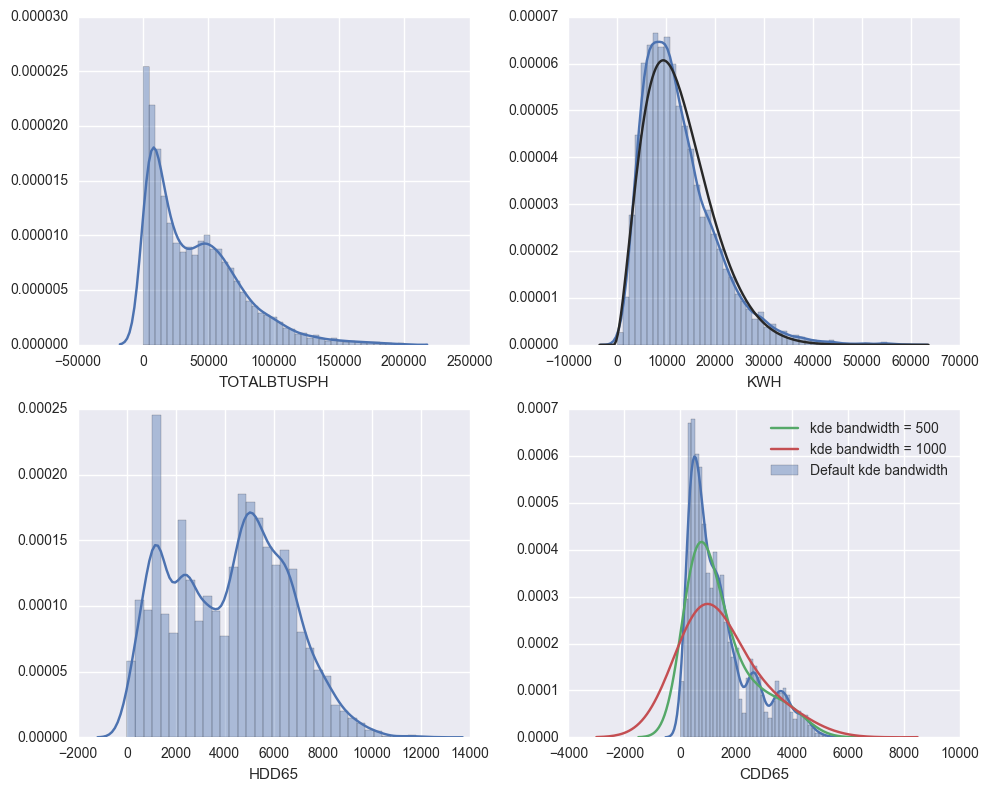

In [32]:
# These four plots show a few of the distplot() parameters.

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8))
sns.distplot(house['TOTALBTUSPH'], ax=ax1)
sns.distplot(house['KWH'], fit=sp.stats.beta, ax=ax2)
sns.distplot(house['HDD65'], ax=ax3)
sns.distplot(house['CDD65'], ax=ax4, label='Default kde bandwidth')
sns.distplot(house['CDD65'], hist=False, kde_kws={'bw':500}, label='kde bandwidth = 500', ax=ax4)
sns.distplot(house['CDD65'], hist=False, kde_kws={'bw':1000}, label='kde bandwidth = 1000', ax=ax4)

plt.tight_layout()

Joint distribution plots can be viewed using either the `kdeplot()` or `jointplot()` functions.

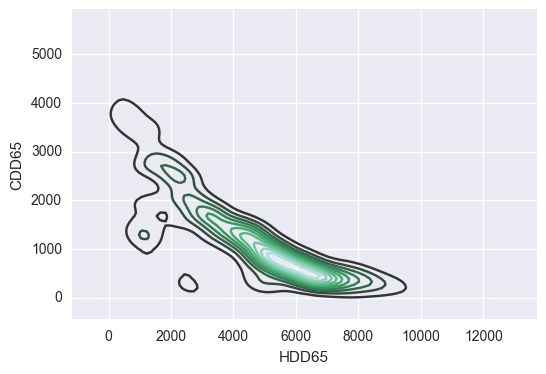

In [46]:
sns.kdeplot(house['HDD65'], house['CDD65'])

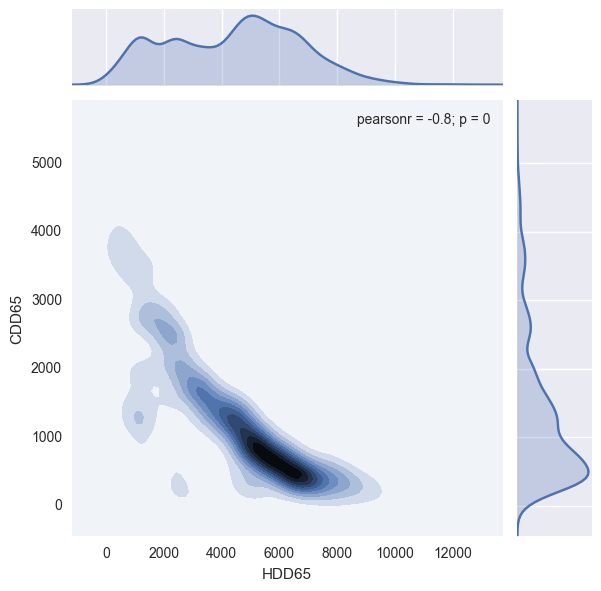

In [14]:
sns.jointplot('HDD65', 'CDD65', data=house, kind='kde')

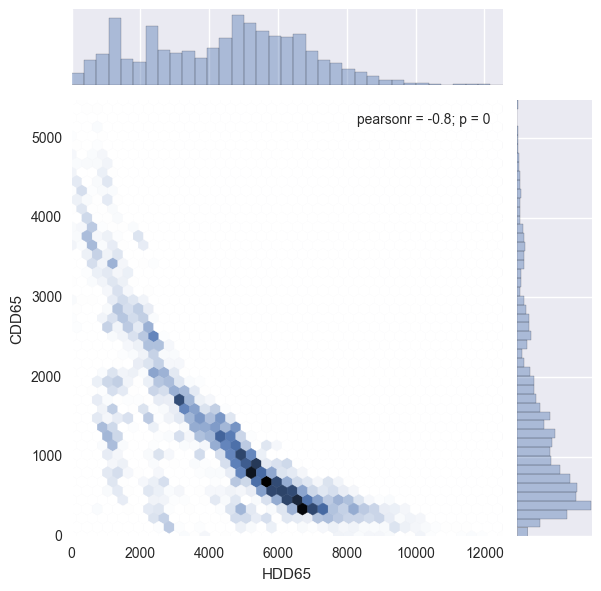

In [15]:
sns.jointplot('HDD65', 'CDD65', data=house, kind='hex')

## Regressions
Regression plots are used to show how one variable in a dataset changes with respect to another variable. The simplest regression plot in seaborn is `regplot()`. It provides a scatter plot with a regression line and shaded 95% confidence interval. 

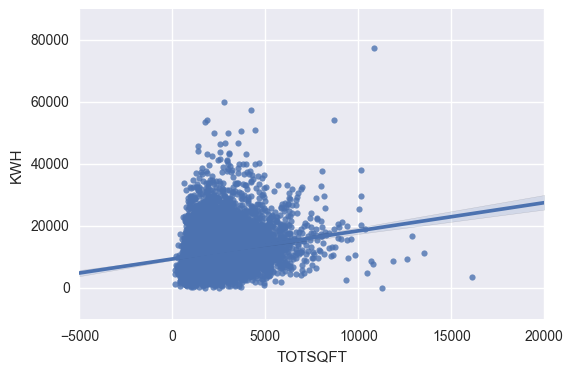

In [16]:
sns.regplot('TOTSQFT', 'KWH', data=house)

Moving just beyond `regplot()`, there are more features to use in `lmplot()`. It has other features such as the ability to add hues or rows and columns for different categorical variables. These features are explored more below in the section on data-aware grids.

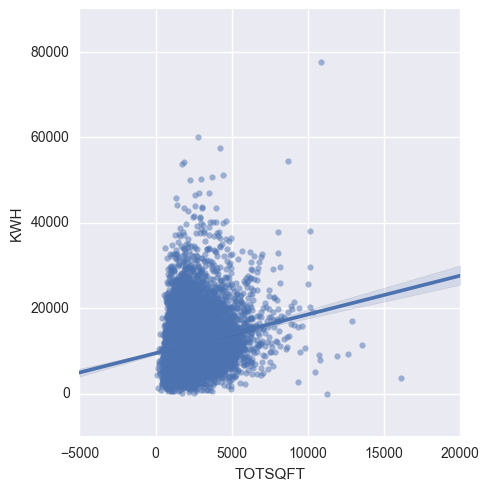

In [19]:
sns.lmplot('TOTSQFT', 'KWH', data=house, scatter_kws={'alpha':0.5})

The `hue`, `col`, and `row` parameters of `lmplot()` show the regressions across a range of different categorical variables. The plot below shows Urban and Rural houses in different colors, and each of the small-multiple plots represents a different climate region. The `col_wrap` parameter forces two of the climates onto a second row as a way to keep the figure a reasonable size.

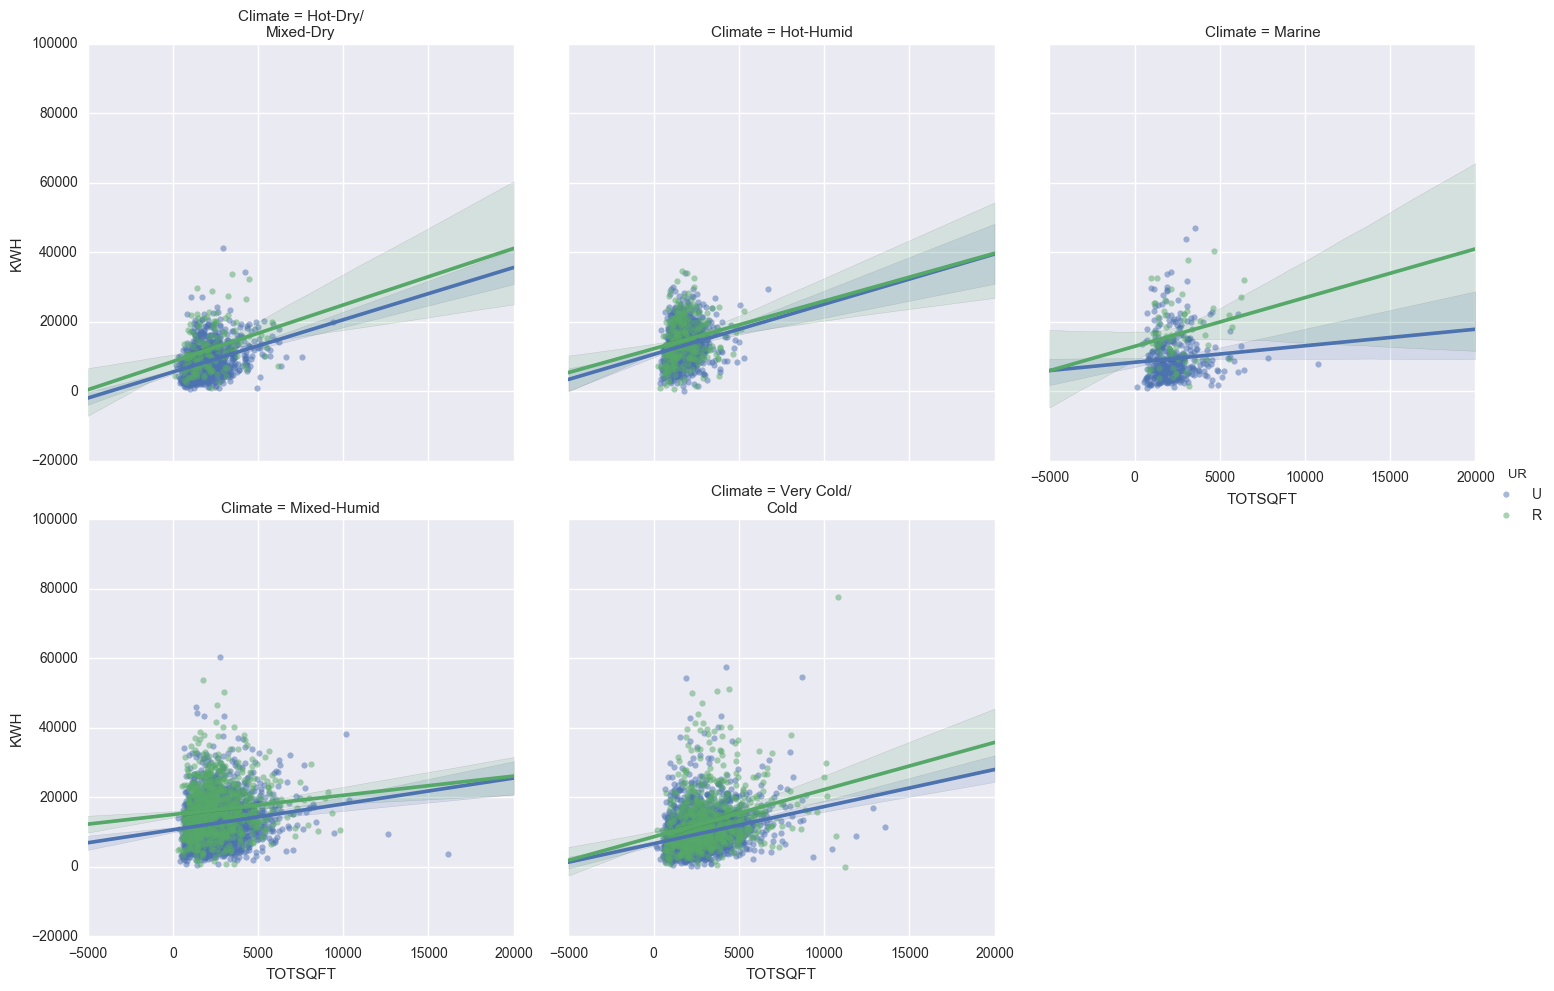

In [20]:
sns.lmplot('TOTSQFT', 'KWH', data=house, hue='UR', col='Climate', col_wrap=3, scatter_kws={'alpha':0.5})

#### Regressions plots with discrete values
Sometimes one of the variables may be ordinal (discrete ordered values). In these cases the resulting figure might not be very helpful. 

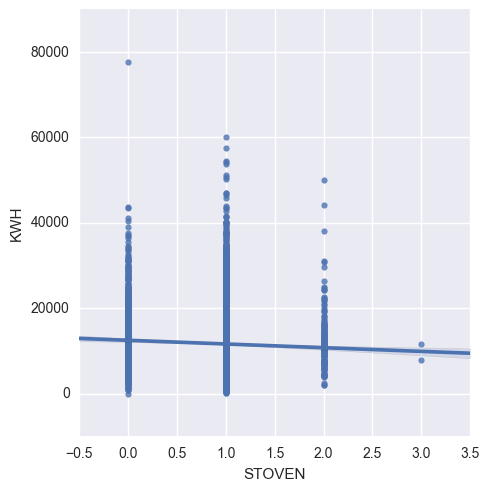

In [24]:
sns.lmplot('STOVEN', 'KWH', house)

With `lmplot()`, it's possible to show the mean (or any other estimator) of each x-value. Seaborn calculates the bootstrapped 95% confidence interval around the estimator by default.

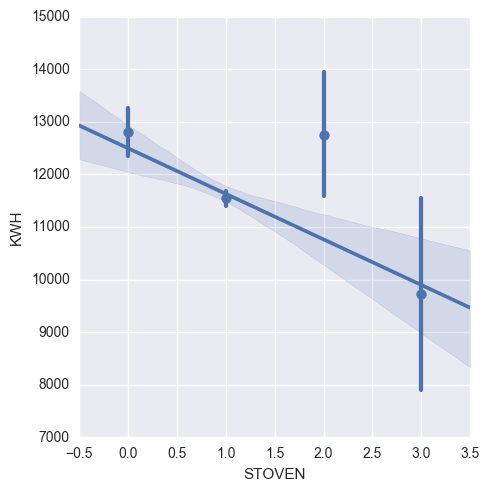

In [23]:
sns.lmplot('STOVEN', 'KWH', house, x_estimator=np.mean)

## Categorical

Categorical plots are used with ordinal or nominal data types. The regression and distribution plots above made use of categorical splits in the data to show multiple plots, but they didn't use those categories on either of the axes. 

#### Common categorical plot types
The four figures below show some of the most common categorical plots, and their features in seaborn. From top-left to bottom-right, they are:

- **Boxplot:** The boxplot, or box and whiskers plot, shows the inner quartiles as a box with the median as a horizontal line. The whiskers extend to show most of the variability in the data, with extreme outliers shown as individual points. This is a common plot for showing the statistical distribution of data.
- **Barplot:** This plot uses the height of each solid bar to show the mean value. Seaborn includes vertical bars that represent the bootstrapped 95% confidence interval around the mean. Notice that the confidence intervals (representing uncertainty in the mean values) are far smaller than might be expected from the wide range of data points shown in the Boxplot. This Barplot might be a good choice when you want to show the mean value (or a different estimator) across a range of categories.
- **Pointplot:** Pointplots look something like a scatterplot, and are not as commonly used for categorical visualizations. The connecting lines between points serves as a useful visual aid when comparing the change, or rate of change, across categories. As with the Barplot, it is possible to specify an estimator other than the mean.
- **Violinplot:** Violinplots put a KDE around a small boxplot. They help show modes in the distribution of a dataset.

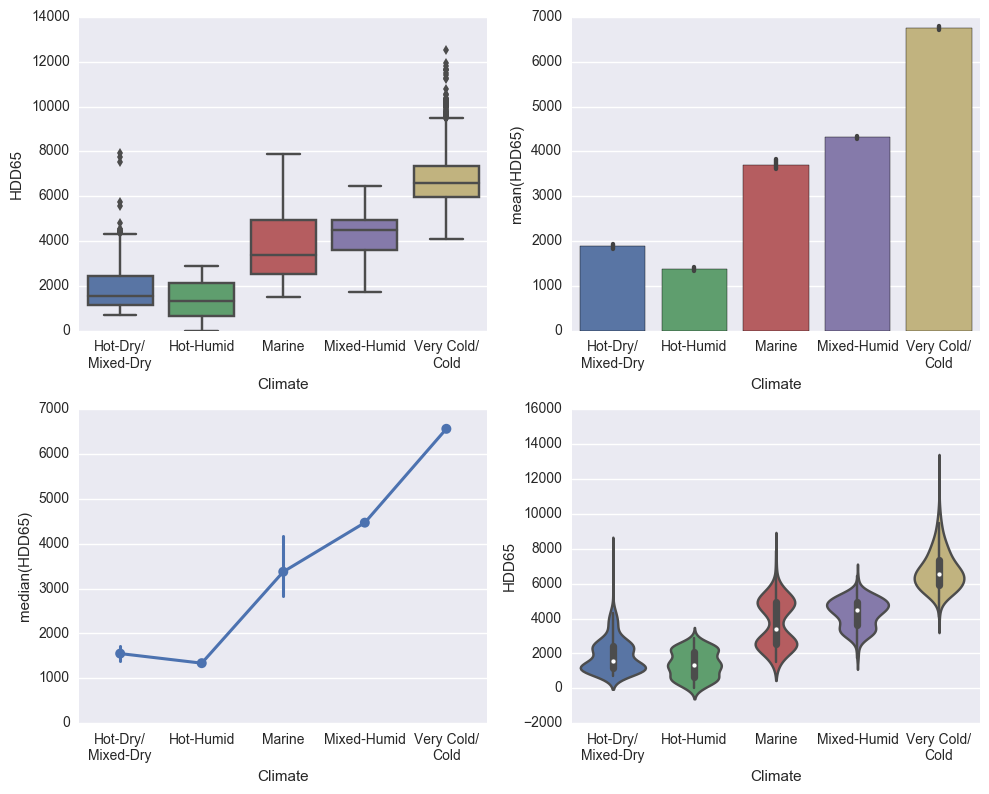

In [33]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8))
sns.boxplot('Climate', 'HDD65', data=house, ax=ax1)
sns.barplot('Climate', 'HDD65', data=house, ax=ax2)
sns.pointplot('Climate', 'HDD65', data=house, scale=0.7, estimator=np.median, ax=ax3)
sns.violinplot('Climate', 'HDD65', data=house, ax=ax4, bw=0.4)

plt.tight_layout()

The advantage of a pointplot is that it provides a clear connection between elements across the axis categories. It is also easy to judge relative change by looking at the slope of the connecting lines. A barplot is less visually cluttered, but may not be as easy to read if the purpose is to look at changes in a different types of housing stock across climate regions.

Moving to a slighty more complicated example, the two figures below add the house type as a hue category. The barplot is beginning to look quite cluttered. It is difficult to compare the same house time across regions, or see how different house types respond differently to the change in climate. By comparison, the pointplot is now easier to read (especially with the `dodge=True` parameter). Notice how the mobile and sigle-family detached homes have much steeper lines than the single-family detached when changing from Mixed-Humid to Very Cold/Cold climates.

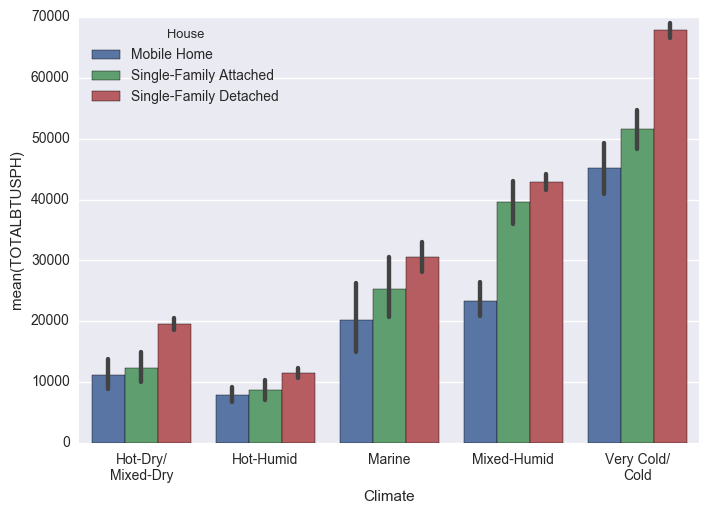

In [110]:
sns.barplot('Climate', 'TOTALBTUSPH', data=house, hue='House')

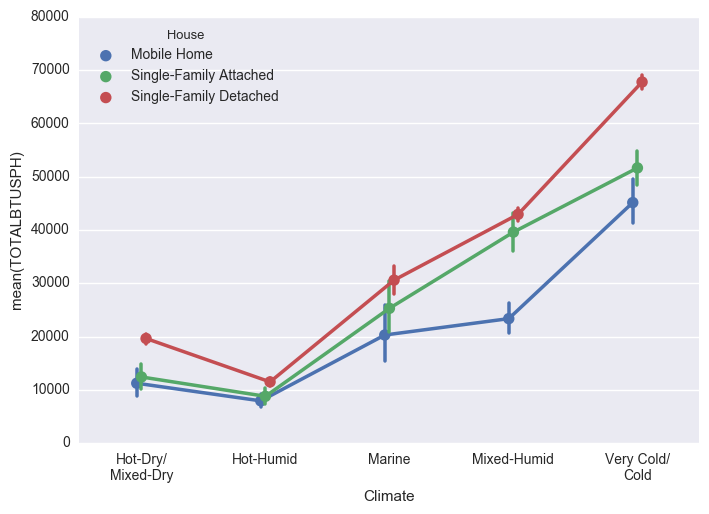

In [39]:
sns.pointplot('Climate', 'TOTALBTUSPH', data=house, hue='House', dodge=True, scale=0.8)

Violinplots may not be as common as bar or boxplots, but they can be just as useful. The figure below shows income distribution across a range of education categories. It splits each violin by another category - if the individual is able to telework. With this plot we can quickly tell that:

- Income generally increases with education level
- Very few people with no schooling are able to telework
- People who can telework generally make more money than others at the same education level

There are many other observations that can be made about the data. Knowing that violinplot assigns equal area by default, is it possible to infer anything about the proportion of employees who have the option to telework within each education category?

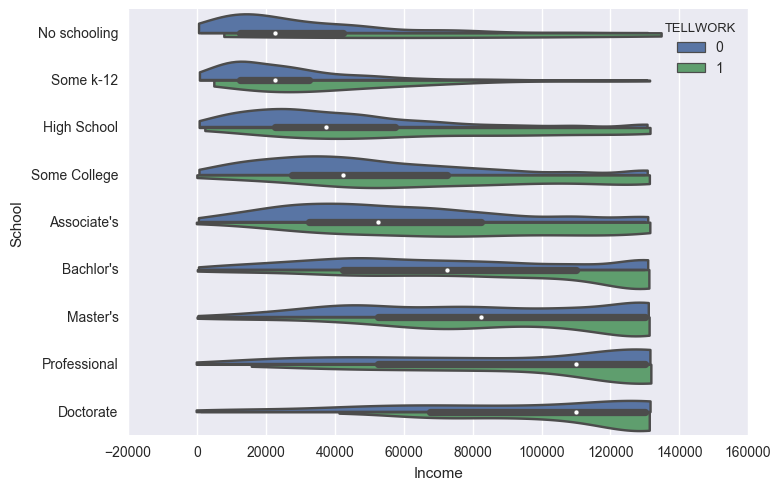

In [38]:
sns.violinplot(y='School', x='Income', hue='TELLWORK', data=df, 
                split=True, cut=.1, orient='h')

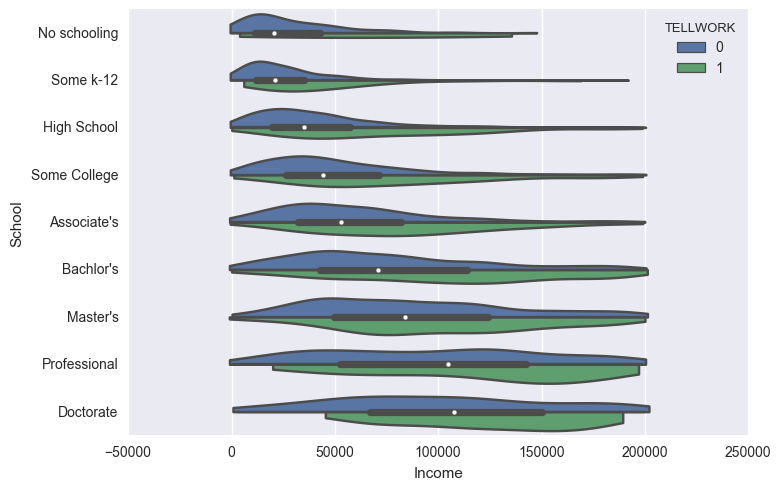

In [68]:
sns.violinplot(y='School', x='Income', hue='TELLWORK', data=df, 
                split=True, cut=.1, orient='h')

The figures below recreates the violinplot as both horizontal and vertical boxplots. Picking between the three of these plots is largely a matter of choice, and will depend on what type of information you are trying to extract from the data. The boxplot figures clearly show the IQR and median values for the TELLWORK options within each education category. But they omit any information about the overall income distribution within each education category. By default the violinplot shows a miniature boxplot inside the violin. Because the plot above splits each side of the violin to show different kde distributions, the inner boxplot provides a third set of information - the median and inner quartiles of all incomes for the education category - that is missing from the boxplots below.

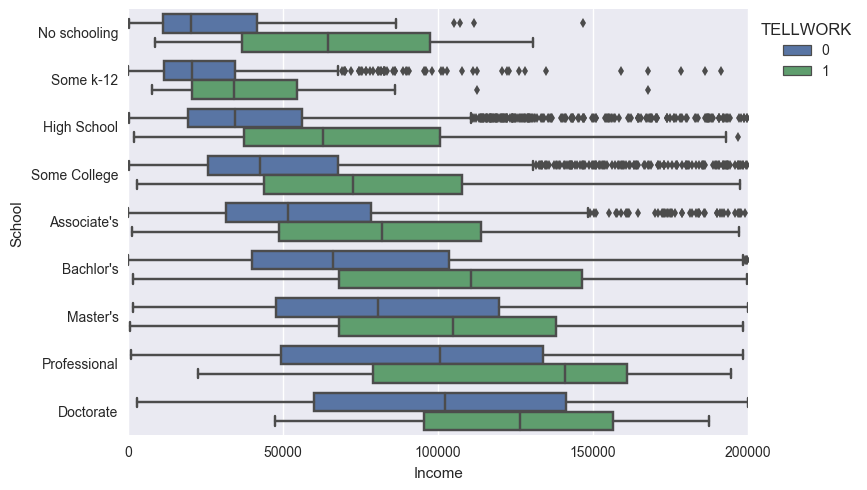

In [69]:
sns.boxplot(y='School', x='Income', hue='TELLWORK', data=df)
plt.legend(bbox_to_anchor=(1, 1), loc=2, title='TELLWORK')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

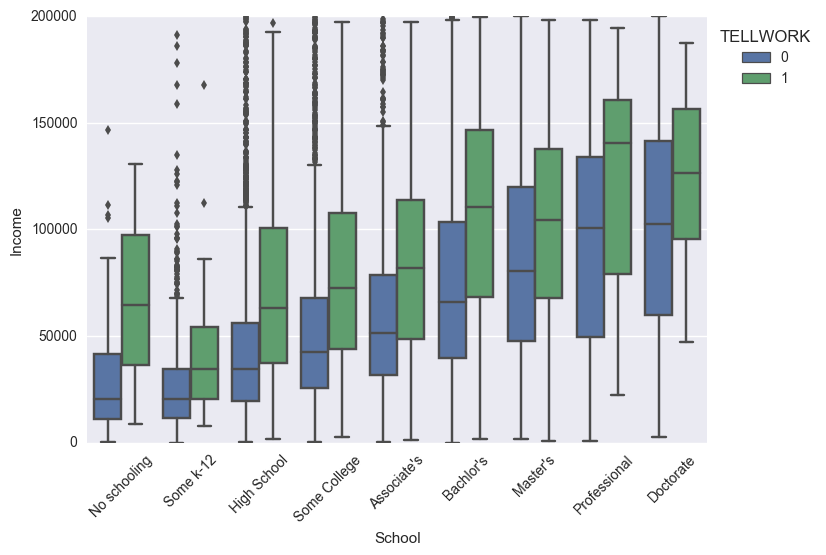

In [70]:
sns.boxplot(x='School', y='Income', hue='TELLWORK', data=df)
plt.legend(bbox_to_anchor=(1, 1), loc=2, title='TELLWORK')
plt.xticks(rotation=45)

## Using Grid objects in Seaborn

We have seen that some functions in seaborn (e.g. `lmplot()`) easily take arguments to split data into hues, rows, or columns based on categorical features. This can be generalized to any type of plot by using `FacetGrid()` objects.

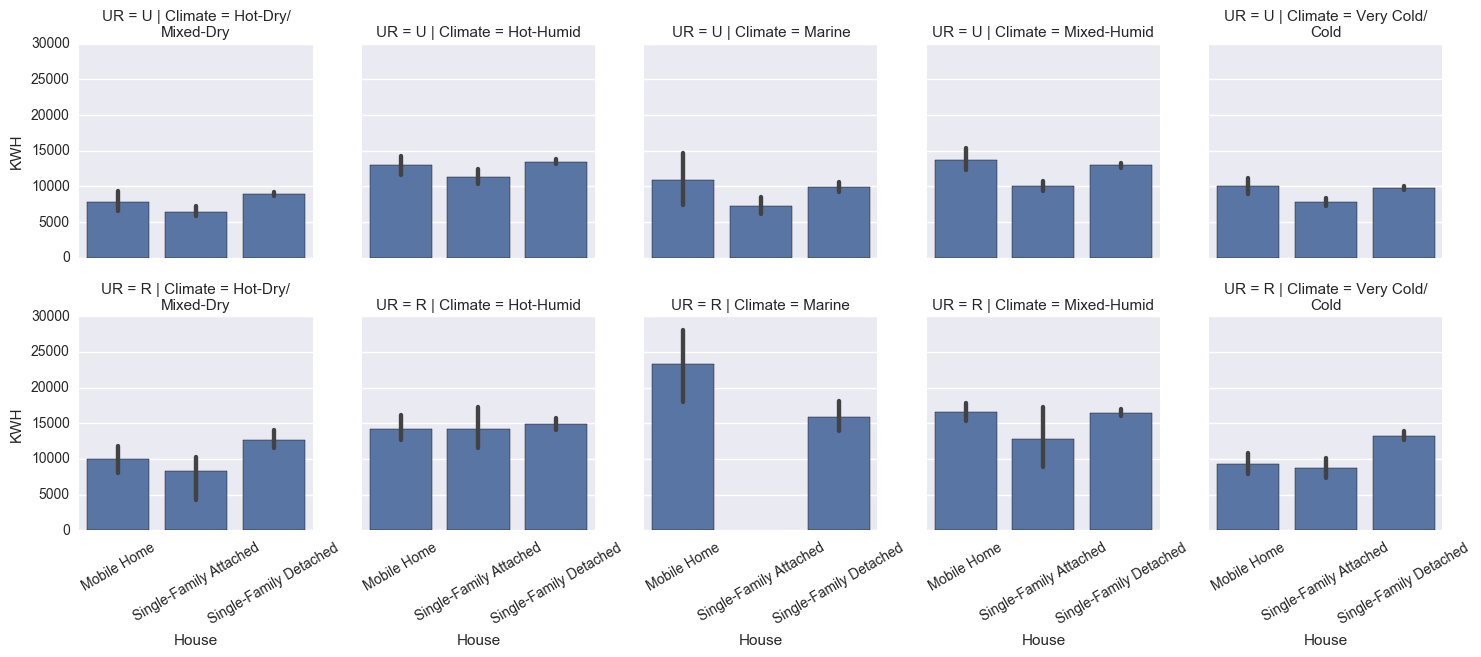

In [58]:
g = sns.FacetGrid(house, row='UR', col='Climate')
g.map(sns.barplot, 'House', 'KWH')
g.set_xticklabels(rotation=30)

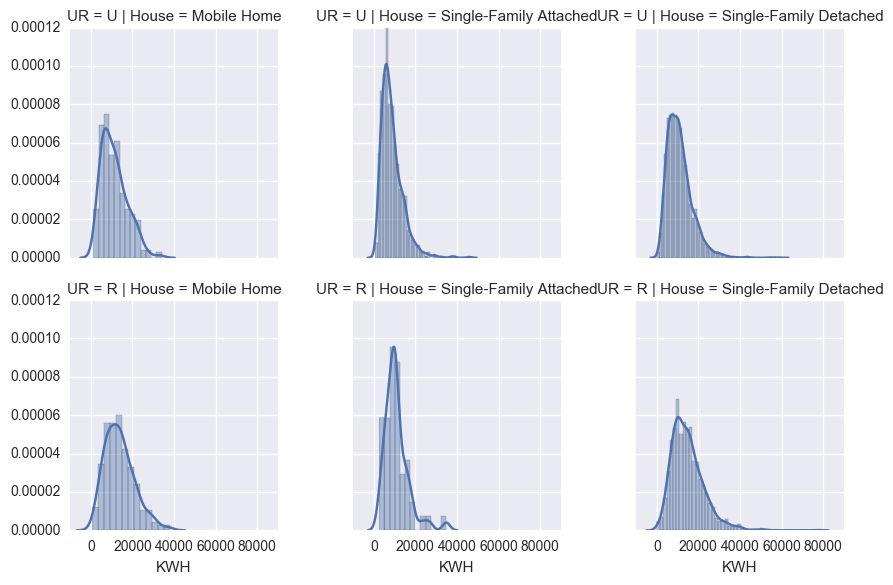

In [60]:
g = sns.FacetGrid(house, row='UR', col='House')
g.map(sns.distplot, 'KWH')
plt.tight_layout()

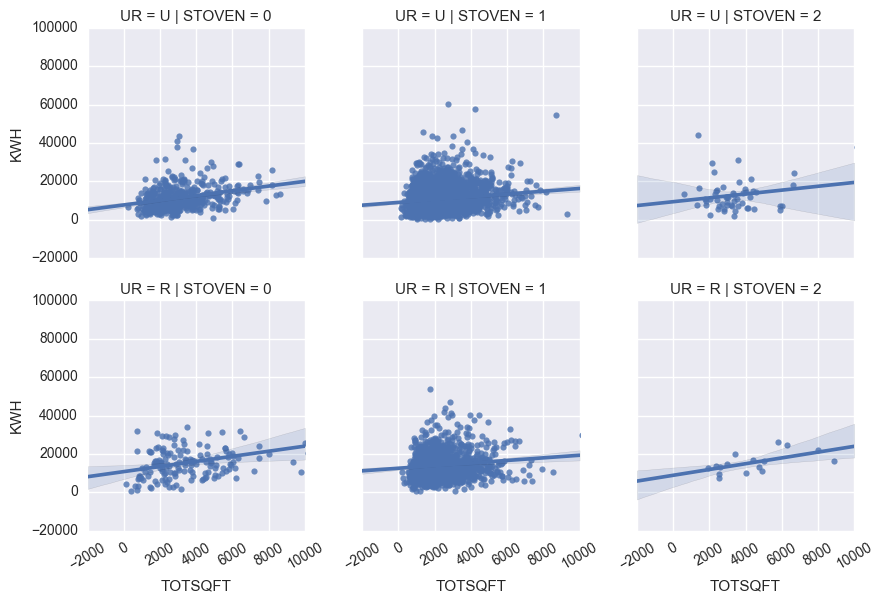

In [82]:
g = sns.FacetGrid(house.sample(5000), row='UR', col='STOVEN')
g.map(sns.regplot, 'TOTSQFT', 'KWH')
g.set_xticklabels(rotation=30)

## Color choices
There are three main categories of color palettes for data visualization: 
1. **Qualitative** (or categorical): Data of different classes or categories. Color does not have a quantitative value assigned to it.
2. **Sequential**: Color represents quantitative values from low to high. There is no natural midpoint to the data.
3. **Diverging**: Color represents quantitative values with a natural midpoint. The midpoint is often 0, but does not always need to be.

### Qualitative color palettes
Qualitative palettes are used to differentiate groups or classes within a dataset. Seaborn provides access to a wide range of prepared qualitative color palettes that can be selected from a default list (as shown below) or from the famous [Color Brewer](http://colorbrewer2.org/) tool. See the [seaborn docs](http://seaborn.pydata.org/tutorial/color_palettes.html#qualitative-color-palettes) for more information and tools.

#### Seaborn defaults
By default, seaborn includes 6 qualitative palettes, called: `deep`, `muted`, `pastel`, `bright`, `dark`, and `colorblind`. The default palette is `deep`, and all of the palettes have 6 colors (notice that the last two colors in the `palplot` objects below are repeats of the first two).


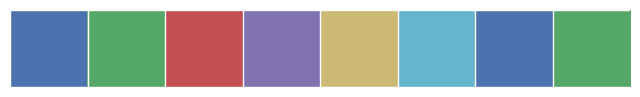

In [5]:
sns.palplot(sns.color_palette('deep', n_colors=8))

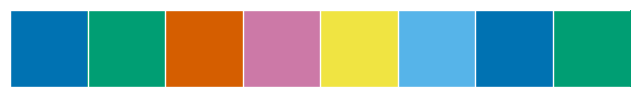

In [13]:
sns.palplot(sns.color_palette('colorblind', n_colors=8))

#### Making your own qualitative palettes
If you want to invest a bit more time in your qualitative color choices, seaborn allows you to pass through any colors (rgb, hex, etc) that you like. Even better, you can use named colors from the [xkcd color survey](https://blog.xkcd.com/2010/05/03/color-survey-results/) - I suggest using this [awesome interactive tool](http://www.luminoso.com/colors/) to pick out your favorite.

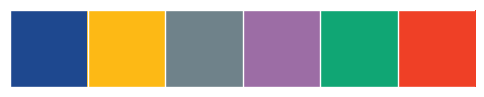

In [63]:
colors = ['cobalt', 'orangey yellow', 'steel grey', 'dark lilac', 'bluish green', 'tomato']
sns.palplot(sns.xkcd_palette(colors))

### Sequential color palettes
Sequential palettes encode some quantitative information from a dataset with upper and lower bounds. Importantly, the data should not have a natural mid-point (that's what you use a [diverging palette](#Diverging-color-palettes) for). Sequential palettes are ideal for kernel density and correlation plots. See the [seaborn docs](http://seaborn.pydata.org/tutorial/color_palettes.html#sequential-color-palettes) for more information and tools.

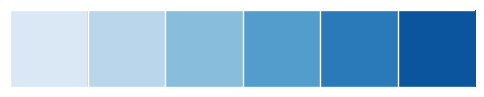

In [64]:
sns.palplot(sns.color_palette('Blues'))

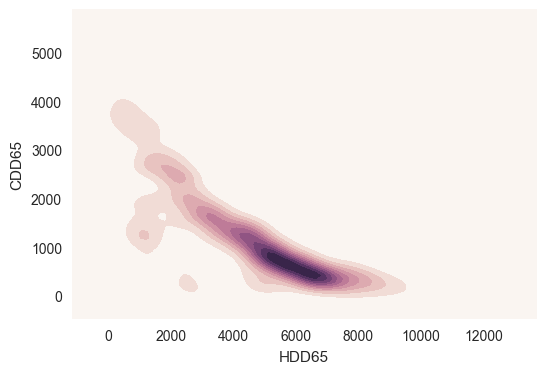

In [53]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.kdeplot(house['HDD65'], house['CDD65'], cmap=cmap, shade=True)

#### Jet  
Under no circumstance will seaborn let you use the Jet colormap. If you aren't familiar with the name, Jet is that rainbow colormap that you've seen in every MATLAB figure and [National Weather Service maps](http://www.weather.gov/forecastmaps). As explained further below, you should never use it.

In [54]:
sns.palplot(sns.color_palette('jet'))

ValueError: No.

### Diverging color palettes
Diverging palettes encode some quantitative information from a dataset with upper and lower bounds, where there is a natural mid-point between the two extremes. Diverging palettes are especially useful when showing the change with respect to a baseline. Diverging palettes usually show one of two different colors on each side of a white mid-point, so don't use two colors (e.g. red/green) that might look the same to some viewers. See the [seaborn docs](http://seaborn.pydata.org/tutorial/color_palettes.html#diverging-color-palettes) for more information and tools.

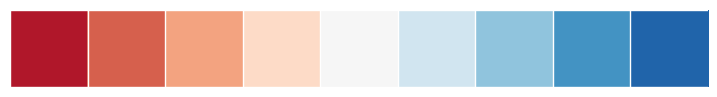

In [55]:
sns.palplot(sns.color_palette('RdBu', 9))

## Other resources
Check out the video below from SciPy2015. It's an amazing tour through color theory that I don't have space to reproduce here. Plus it gives a thorough explanation of why you should never user Jet. If you don't have 20 minutes, at least check out [this blog post](http://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/).

In [79]:
from IPython.display import HTML
HTML('<iframe width="640" height="360" src="https://www.youtube.com/embed/xAoljeRJ3lU" frameborder="0" allowfullscreen></iframe>')

# Data import

In [78]:
# Read in a portion of the raw data
input_columns = ['TYPEHUQ', 'EDUCATION', 'MONEYPY', 'Climate_Region_Pub', 'UR',
                 'TOTSQFT', 'HDD65', 'CDD65', 'KWH', 'TOTALBTUSPH', 'STOVEN', 'TELLWORK']

fn = 'recs2009_public.csv'
df = pd.read_csv(fn, usecols=input_columns, na_values=[-2])

In [61]:
# Several of the columns have integer values that need to be translated
df.head()

,TYPEHUQ,HDD65,CDD65,Climate_Region_Pub,UR,STOVEN,EDUCATION,TELLWORK,MONEYPY,TOTSQFT,KWH,TOTALBTUSPH
0,2,4742,1080,4,U,1,5,0,23,5075,18466,10873
1,2,2662,199,5,U,1,2,0,9,3136,5148,38606
2,5,6233,505,1,U,1,6,0,18,528,2218,40248
3,2,6034,672,1,U,0,2,0,10,2023,10015,40196
4,3,5388,702,1,U,1,5,0,20,1912,2869,36136


In [72]:
# Read in pre-defined translations
# Income translation uses random uniform from within defined income ranges
income_df = pd.read_excel('Translations.xlsx', 'Income', index_col=0)
education_df = pd.read_excel('Translations.xlsx', 'Education', index_col=0)
house_df = pd.read_excel('Translations.xlsx', 'House_stock', index_col=0)
climate_df = pd.read_excel('Translations.xlsx', 'Climate_region', index_col=0)

def translate(codebook, code):
    if codebook.columns == 'income':
        low = codebook.loc[code-1].values[0]
        high = codebook.loc[code+1].values[0]
        return np.random.randint(low, high)
    else:
        return codebook.loc[code].values[0]

In [73]:
# Translate columns 
df['Income'] = df['MONEYPY'].apply(lambda x: translate(income_df, x))
df['School'] = df['EDUCATION'].apply(lambda x: 
                                     translate(education_df, x)).astype('category', 
                                              categories=education_df['Education'].tolist())
df['House'] = df['TYPEHUQ'].apply(lambda x: translate(house_df, x)).astype('category')
df['Climate'] = df['Climate_Region_Pub'].apply(lambda x: translate(climate_df, x)).astype('category')


In [76]:
# Remove apartments from the dataset and drop the categories
# Remove translated columns from the dataset
# New DataFrame is named 'house'
house = df[(df['TYPEHUQ'] != 4) & (df['TYPEHUQ'] != 5)]
house.drop(['MONEYPY', 'EDUCATION', 'TYPEHUQ', 'Climate_Region_Pub'], axis=1, inplace=True)
house.loc[:,'House'] = house.loc[:,'House'].cat.remove_categories(['Apartment in Building with 2-4 units', 
                                       'Apartment in Building with 5+ units'])

/Users/Home/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [77]:
house.head()

,HDD65,CDD65,UR,STOVEN,TELLWORK,TOTSQFT,KWH,TOTALBTUSPH,Income,School,House,Climate
0,4742,1080,U,1,0,5075,18466,10873,126156,Bachlor's,Single-Family Detached,Mixed-Humid
1,2662,199,U,1,0,3136,5148,38606,28899,High School,Single-Family Detached,Marine
3,6034,672,U,0,0,2023,10015,40196,37180,High School,Single-Family Detached,Very Cold/\nCold
4,5388,702,U,1,0,1912,2869,36136,84214,Bachlor's,Single-Family Attached,Very Cold/\nCold
5,8866,270,U,1,0,3485,6387,74100,14365,Associate's,Single-Family Detached,Very Cold/\nCold


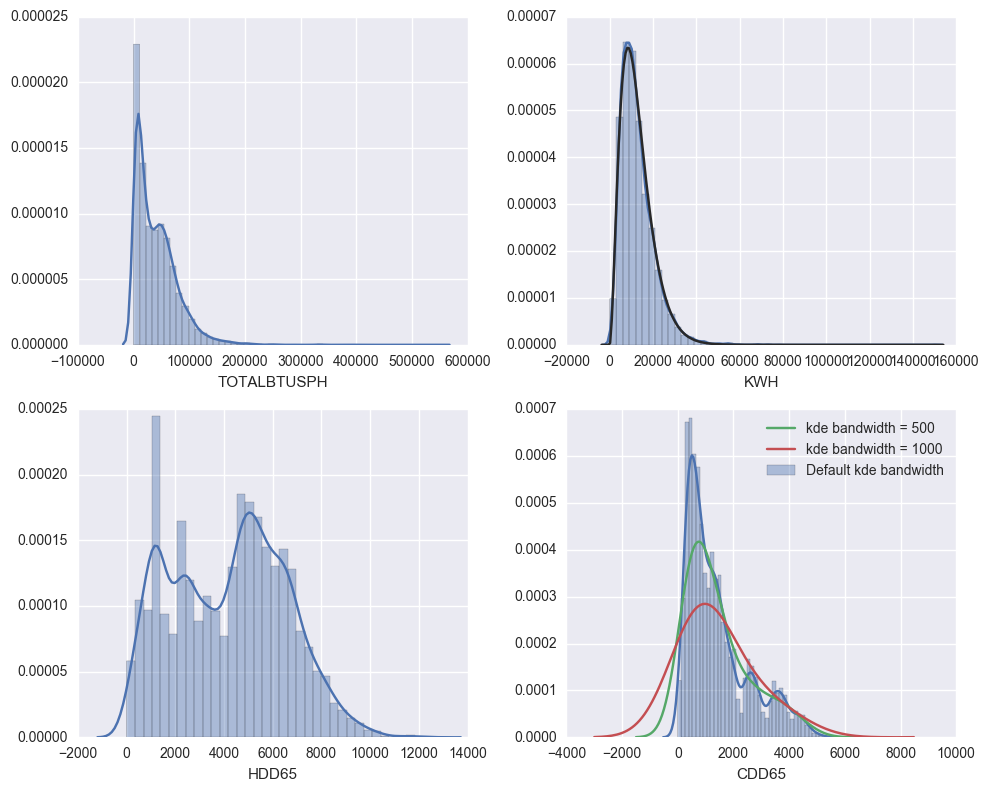

In [30]:
# These four plots show a few of the distplot() parameters.

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8))
sns.distplot(house['TOTALBTUSPH'], ax=ax1)
sns.distplot(house['KWH'], fit=sp.stats.beta, ax=ax2)
sns.distplot(house['HDD65'], ax=ax3)
sns.distplot(house['CDD65'], ax=ax4, label='Default kde bandwidth')
sns.distplot(house['CDD65'], hist=False, kde_kws={'bw':500}, label='kde bandwidth = 500', ax=ax4)
sns.distplot(house['CDD65'], hist=False, kde_kws={'bw':1000}, label='kde bandwidth = 1000', ax=ax4)

plt.tight_layout()

In both categories there are a few very large values that I'll filter out to make the plots easier to view.

In [31]:
house = house[(house['TOTALBTUSPH']<200000) &
              (house['KWH']<60000)]